In [95]:
import os
import sys
import importlib
import glob
import time
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.RationalApproximation import RationalApproximation_AAA
from scipy.special import gamma 
import scipy
from scipy.integrate import solve_ivp

import pandas as pd 

In [238]:
class Two_sided_ODE_problem: 
    def __init__(self,
                 beta0, beta1, poles01, weights01,  # for sigma 
                 gamma0, gamma1, kappas01, thetas01,  # for u 
                 omega, lamdba): 

        # for sigma 
        self.beta0 = beta0
        self.beta1 = beta1
        self.poles01 = poles01
        self.weights01 = weights01
        self.m01 = self.poles01.shape[0]

        # for u 
        self.gamma0 = gamma0
        self.gamma1 = gamma1
        self.kappas01 = kappas01
        self.thetas01 = thetas01
        self.n01 = self.kappas01.shape[0]

        # problem parameters  
        self.omega = omega
        self.lamdba = lamdba

        # vectorize evaluation 
        self.fun = np.vectorize(self.eval)

    def eval(self, t,y):
        # 0 -> u
        # 1 -> dt u 
        # 2 -> sigma 
        # 01 u modes -> n01 many 
        # 01 sigma modes -> m01 many 

        x = 0 * y

        # Derivative of u: 
        x[0] = y[1]
                
        # 2nd derivative of u  
        x[1] = f(t) - y[2] - self.omega**2 * y[0]

        # 2nd derivative of sigma: 
        x[2] = 1 / self.beta1 * (self.gamma0 * y[0] 
                                 + self.gamma1 * y[1]
                                 - np.sum(self.kappas01 * y[3:self.n01+3])
                                 - self.beta0 * y[2]
                                 + np.sum(self.poles01 * y[self.n01+3:self.n01+self.m01+3]))

        # Mode equations for u 01 
        x[3:self.n01+3] = - self.kappas01 * y[3:self.n01+3] + self.thetas01 * y[0]

        # Mode equations for sigma 01 
        x[self.n01+3:self.n01+self.m01+3] = - self.poles01 * y[self.n01+3:self.n01+self.m01+3] + self.weights01 * y[2]

        return x 
    

class MultiTermKernel: 

    def __init__(self, phis, alphas, **kwargs):
        self.phis = phis
        self.alphas = alphas

        self.RATarget = np.vectorize(self.eval_RATarget) 
        self.kernel = np.vectorize(self.eval_kernel)

    def eval_kernel(self, t):
        return np.sum(self.phis / gamma(1 - self.alphas) * t **(-self.alphas))
    
    def eval_RATarget(self, t):
        return np.sum(self.phis * t ** (1 - self.alphas))
    

In [269]:
# Distribution psi for u 
@np.vectorize
def Distribution_u(alpha): 
    b = 0.2
    return b ** alpha # * (alpha <= 1)

# Distribution phi for sigma 
@np.vectorize
def Distribution_sigma(alpha): 
    a = 0.1 
    return a ** alpha # * (alpha <= 1)

# Right side of the equation 
# @np.vectorize
def f(t): 
    omega = 3
    Omega = 1.2 * omega 
    return np.sin(Omega * t)

# Analytical solution 
@np.vectorize
def sol_u(t): 
    return t

In [270]:
#########################################
### Quadrature of the integral 
#########################################

n_QF = 2 ** 15
# two additional points for 0 and 1 
QFweight = 1 / (n_QF+2)
quadraturePoints01 = np.arange(0 + 0.5/n_QF,1 + 0.5/n_QF, 1/n_QF)

phis_u_01 = Distribution_u(quadraturePoints01) * QFweight
phi_u_0 = Distribution_u(0) * QFweight
phi_u_1 = Distribution_u(1) * QFweight

phis_sigma_01 = Distribution_sigma(quadraturePoints01) * QFweight
phi_sigma_0 = Distribution_sigma(0) * QFweight
phi_sigma_1 = Distribution_sigma(1) * QFweight

MTK_u_01 = MultiTermKernel(phis_u_01,quadraturePoints01)
MTK_sigma_01 = MultiTermKernel(phis_sigma_01,quadraturePoints01)

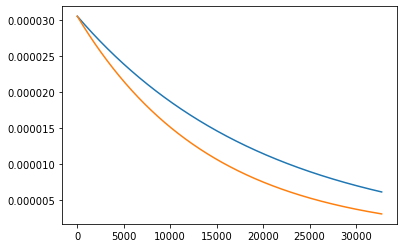

In [271]:
plt.plot(phis_u_01)
plt.plot(phis_sigma_01)

In [277]:
#########################################
### Simulation and error  
#########################################

T = 100
omega = 3 
Omega = 1.2 * omega 
lamdba = 1 

error_u = [] 

#########################################
### Rational Approximation of the Integral Kernel of u 
#########################################

Zmin, Zmax = 1/T,1/1e-6
tol = 1.e-10
MaxDegree = 30
nSupportPoints = 100

RA_u_01 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK_u_01.RATarget)

weights_u_01 = RA_u_01.c
poles_u_01 = RA_u_01.d
winf_u_01 = RA_u_01.c_inf
m_u_01 = weights_u_01.shape[0]

print(weights_u_01.shape, poles_u_01.shape, m_u_01)

beta_u_0 = phi_u_0 + np.sum(weights_u_01)
beta_u_1 = phi_u_1 + winf_u_01

#########################################
### Rational Approximation of the Integral Kernel of u 
#########################################

Zmin, Zmax = 1/T,1/1e-6
tol = 1.e-10
MaxDegree = 30
nSupportPoints = 100

RA_sigma_01 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                        TargetFunction=MTK_sigma_01.RATarget)

weights_sigma_01 = RA_sigma_01.c
poles_sigma_01 = RA_sigma_01.d
winf_sigma_01 = RA_sigma_01.c_inf
m_sigma_01 = weights_sigma_01.shape[0]

print(weights_sigma_01.shape, poles_sigma_01.shape, m_sigma_01)

beta_sigma_0 = phi_sigma_0 + np.sum(weights_sigma_01)
beta_sigma_1 = phi_sigma_1 + winf_sigma_01

#########################################
### Numerical Scheme 
#########################################

problem = Two_sided_ODE_problem(beta0 = beta_sigma_0, beta1 = beta_sigma_1, poles01 = poles_sigma_01, weights01= weights_sigma_01, 
                                gamma0 = beta_u_0, gamma1 = beta_u_1, kappas01= poles_u_01, thetas01=weights_u_01,  
                                omega=omega, lamdba=lamdba)

t_span = (0.,T)
y0 = [0] * (3 + m_u_01 + m_sigma_01)

# initial conditions are zero     
sol = solve_ivp(problem.eval, t_span, y0, method='BDF', max_step=0.01)

#########################################
### Compute error 
#########################################

# error_u.append(dt * np.linalg.norm(sol_u(sol.t) - sol.y[0]))


(25,) (25,) 25
(25,) (25,) 25


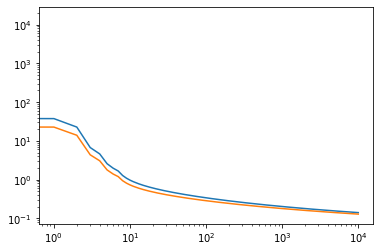

In [278]:
plt.loglog([RA_u_01.appx_ker(t) for t in sol.t])
plt.loglog([RA_sigma_01.appx_ker(t) for t in sol.t])

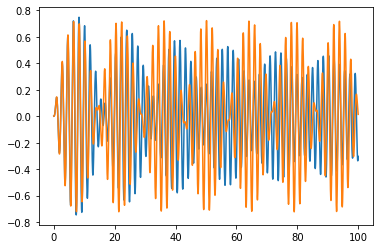

In [279]:
plt.plot(sol.t, sol.y[0])
#plt.plot(sol.t, sol.y[2])

a = 10 
b = 3.6 
c = -b / (a**0.5* (a-b**2))
d = 0

plt.plot(sol.t,[np.sin(b*t) / (a-b**2) + c * np.sin(a**0.5*t) + d * np.cos(a**0.5*t) for t in sol.t])

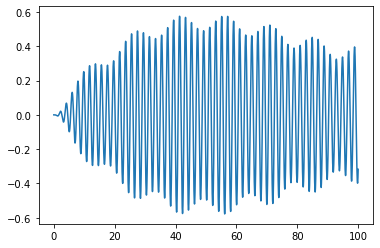

In [281]:
a = 10 
b = 3.6 
c = -b / (a**0.5* (a-b**2))
d = 0

plt.plot(sol.t, sol.y[0] - np.asarray([np.sin(b*t) / (a-b**2) + c * np.sin(a**0.5*t) + d * np.cos(a**0.5*t) for t in sol.t]))

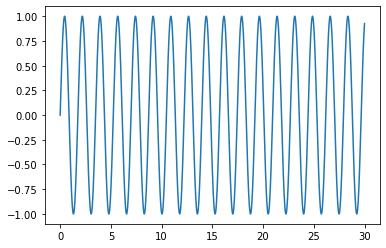

In [267]:
plt.plot(sol.t, [f(t) for t in sol.t])